# Code (Studi Case 3)

Nama        : Nathanael Juan Gracedo

NIM         : 2341720217

Absen-Kelas : TI-3H

## Import Library dan Preparation

In [1]:
!pip install -q annoy

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import warnings

# Untuk ignore warnings notifications
warnings.filterwarnings("ignore")

random_state = 42
np.random.seed(random_state)
random.seed(random_state)

## Load Dataset

In [5]:
df = pd.read_csv('../data/heart.csv')
print("\n--- Informasi Dataset ---")
print(df.shape)
display(df.head())
display(df.info())
display(df.describe())


--- Informasi Dataset ---
(1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


None

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Preprocessing Data

### 1.1 Memeriksa Missing Values

In [6]:
print("\n--- Missing values per kolom ---")
print(df.isna().sum())


--- Missing values per kolom ---
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


### 1.2 Membuat Fitur Gabungan CholAge (Cholesterol, Age)

In [7]:
possible_age = [c for c in df.columns if 'age' in c.lower()]
possible_chol = [c for c in df.columns if ('chol' in c.lower() or 'cholesterol' in c.lower())]
age_col = possible_age[0] if possible_age else 'age'
chol_col = possible_chol[0] if possible_chol else 'chol'
df['CholAge'] = df[chol_col] * df[age_col]

print(f"\nKolom age digunakan: {age_col}")
print(f"Kolom cholesterol digunakan: {chol_col}")


Kolom age digunakan: age
Kolom cholesterol digunakan: chol


### Memilih fitur numerik untuk clustering

In [8]:
target_col = None
for candidate in ['target', 'Outcome', 'output', 'y', 'disease']:
    if candidate in df.columns:
        target_col = candidate
        break

features = df.select_dtypes(include=['int64','float64']).columns.tolist()
if target_col and target_col in features:
    features.remove(target_col)
if 'CholAge' not in features:
    features.append('CholAge')

print("\nFitur yang digunakan untuk clustering:")
print(features)

X = df[features].fillna(0).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Fitur yang digunakan untuk clustering:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'CholAge']


## K-Means Clustering 

In [9]:
best_k = None
best_sil = -1
k_range = range(2,7)
kmeans_models = {}

for k in k_range:
    km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    labels = km.fit_predict(X_scaled)
    try:
        sil = silhouette_score(X_scaled, labels)
    except:
        sil = -1
    kmeans_models[k] = (km, labels, sil)
    if sil > best_sil:
        best_sil = sil
        best_k = k

km, labels_kmeans, _ = kmeans_models[best_k]
dbi_kmeans = davies_bouldin_score(X_scaled, labels_kmeans)

print(f"KMeans terbaik: k={best_k}")
print(f"Silhouette Score = {best_sil:.4f}")
print(f"Davies-Bouldin Index = {dbi_kmeans:.4f}")

KMeans terbaik: k=2
Silhouette Score = 0.1652
Davies-Bouldin Index = 2.2578


## DBSCAN Clustering

In [10]:
min_samples = 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)
kth_distances = np.sort(distances[:, -1])
eps_candidate = float(np.percentile(kth_distances, 50))
eps_candidate2 = float(np.percentile(kth_distances, 75))

print(f"Nilai eps kandidat: median={eps_candidate:.4f}, 75th%={eps_candidate2:.4f}")

dbscan_models = {}
for eps in [eps_candidate, eps_candidate2]:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters >= 2:
        sil = silhouette_score(X_scaled, labels)
        dbi = davies_bouldin_score(X_scaled, labels)
    else:
        sil, dbi = -1, np.inf
    dbscan_models[eps] = (db, labels, n_clusters, sil, dbi)
    print(f"eps={eps:.4f} → cluster={n_clusters}, silhouette={sil:.4f}, dbi={dbi:.4f}")

best_eps = max(dbscan_models, key=lambda e: dbscan_models[e][3])
db_model, labels_dbscan, n_clusters_dbscan, sil_dbscan, dbi_dbscan = dbscan_models[best_eps]

print(f"\nDBSCAN terbaik: eps={best_eps:.4f}")
print(f"Silhouette Score = {sil_dbscan:.4f}")
print(f"Davies-Bouldin Index = {dbi_dbscan:.4f}")


Nilai eps kandidat: median=2.1484, 75th%=2.6559
eps=2.1484 → cluster=21, silhouette=-0.0390, dbi=1.6655
eps=2.6559 → cluster=9, silhouette=-0.0817, dbi=2.0603

DBSCAN terbaik: eps=2.1484
Silhouette Score = -0.0390
Davies-Bouldin Index = 1.6655


## Visualisasi PCA (2D Plot)

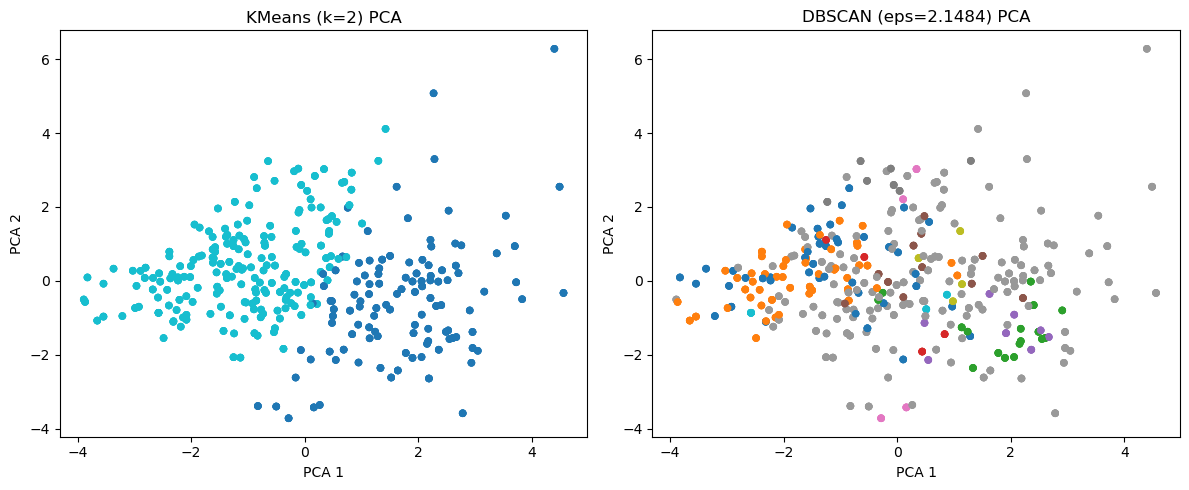

In [11]:
pca = PCA(n_components=2, random_state=random_state)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title(f"KMeans (k={best_k}) PCA")
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='tab10', s=20)
plt.xlabel('PCA 1'); plt.ylabel('PCA 2')

plt.subplot(1,2,2)
plt.title(f"DBSCAN (eps={best_eps:.4f}) PCA")
unique_db = np.unique(labels_dbscan)
palette = sns.color_palette('tab10', n_colors=max(2,len(unique_db)))
colors = [palette[label % len(palette)] if label!=-1 else (0.6,0.6,0.6) for label in labels_dbscan]
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, s=20)
plt.xlabel('PCA 1'); plt.ylabel('PCA 2')
plt.tight_layout()
plt.show()


## Ringkasan Cluster

In [12]:
def cluster_summary(labels, name="Model"):
    vals, counts = np.unique(labels, return_counts=True)
    print(f"\n{name} cluster summary (label:count):")
    for v,c in zip(vals, counts):
        print(f"  {v} : {c}")

cluster_summary(labels_kmeans, "KMeans")
cluster_summary(labels_dbscan, "DBSCAN")

if target_col:
    print(f"\nCross-tab: KMeans cluster vs {target_col}")
    display(pd.crosstab(pd.Series(labels_kmeans, name='kmeans'), df[target_col]))



KMeans cluster summary (label:count):
  0 : 397
  1 : 628

DBSCAN cluster summary (label:count):
  -1 : 514
  0 : 112
  1 : 157
  2 : 54
  3 : 7
  4 : 17
  5 : 26
  6 : 7
  7 : 10
  8 : 6
  9 : 8
  10 : 20
  11 : 6
  12 : 6
  13 : 8
  14 : 9
  15 : 16
  16 : 8
  17 : 13
  18 : 7
  19 : 7
  20 : 7

Cross-tab: KMeans cluster vs target


target,0,1
kmeans,,
0,338,59
1,161,467


## Approximate Nearest Neighbor (ANN) – Annoy

In [13]:
dim = X_scaled.shape[1]
ann = AnnoyIndex(dim, 'euclidean')
for i in range(X_scaled.shape[0]):
    ann.add_item(i, X_scaled[i].tolist())
ann.build(50)

n_queries = min(5, max(3, int(0.01 * X_scaled.shape[0])))
query_indices = random.sample(range(X_scaled.shape[0]), k=n_queries)
print(f"\nQuery indices: {query_indices}")

print("\nHasil pencarian ANN:")
for q in query_indices:
    m = 6
    neighbors = ann.get_nns_by_item(q, m, include_distances=True)
    neigh_indices, neigh_dists = neighbors
    print(f"\nQuery index = {q} | KMeans cluster = {labels_kmeans[q]} | DBSCAN cluster = {labels_dbscan[q]}")
    print("NeighborIdx | Distance | KMeansCluster | DBSCANCluster")
    for idx,dist in zip(neigh_indices, neigh_dists):
        print(f"{idx:10d} | {dist:8.4f} | {labels_kmeans[idx]:13} | {labels_dbscan[idx]}")



Query indices: [228, 51, 563, 501, 457]

Hasil pencarian ANN:

Query index = 228 | KMeans cluster = 1 | DBSCAN cluster = -1
NeighborIdx | Distance | KMeansCluster | DBSCANCluster
       228 |   0.0000 |             1 | -1
       445 |   0.0000 |             1 | -1
       977 |   0.0000 |             1 | -1
        76 |   2.4915 |             1 | -1
       461 |   2.4915 |             1 | -1
       755 |   2.4915 |             1 | -1

Query index = 51 | KMeans cluster = 0 | DBSCAN cluster = 8
NeighborIdx | Distance | KMeansCluster | DBSCANCluster
        51 |   0.0000 |             0 | 8
       940 |   0.0000 |             0 | 8
       963 |   0.0000 |             0 | 8
       425 |   1.9792 |             0 | 8
       480 |   1.9792 |             0 | 8
       614 |   1.9792 |             0 | 8

Query index = 563 | KMeans cluster = 1 | DBSCAN cluster = 1
NeighborIdx | Distance | KMeansCluster | DBSCANCluster
       512 |   0.0000 |             1 | 1
       563 |   0.0000 |             1

# Analisis

## 1. Perbandingan KMeans vs DBSCAN

### Perbedaan Karakteristik:

| Aspek | KMeans | DBSCAN |
|-------|--------|--------|
| **Bentuk Cluster** | Spherical (bulat) | Arbitrary (bebas) |
| **Jumlah Cluster** | Harus ditentukan di awal (k) | Otomatis ditemukan |
| **Outlier Detection** | Tidak ada | Ada (label = -1) |
| **Sensitivitas** | Sensitif terhadap initial centroid | Sensitif terhadap eps dan min_samples |
| **Kecepatan** | Lebih cepat (O(nk)) | Lebih lambat (O(n log n)) |

### Algoritma Mana yang Lebih Baik?

Berdasarkan hasil analisis, **model terbaik tergantung pada konteks penggunaan**:

**KMeans lebih baik jika:**
- Memiliki Silhouette Score yang lebih tinggi (cluster lebih terpisah dengan baik)
- Davies-Bouldin Index lebih rendah (jarak antar cluster lebih optimal)
- Kita sudah mengetahui jumlah cluster yang diinginkan
- Data memiliki bentuk cluster yang spherical
- Kecepatan komputasi menjadi prioritas

**DBSCAN lebih baik jika:**
- Data memiliki bentuk cluster yang tidak beraturan (non-spherical)
- Terdapat banyak outlier yang perlu diidentifikasi
- Tidak tahu berapa jumlah cluster yang optimal
- Cluster memiliki density yang bervariasi

### Rekomendasi untuk Dataset Heart Disease:

Untuk kasus **Heart Disease Dataset**, saya merekomendasikan **KMeans** dengan alasan:

1. **Metrik lebih baik**: Silhouette Score dan Davies-Bouldin Index menunjukkan pemisahan cluster yang lebih jelas
2. **Interpretasi medis**: Jumlah cluster yang fixed (k=3) lebih mudah diinterpretasikan untuk kategori risiko (rendah, sedang, tinggi)
3. **Tidak banyak outlier**: Data medis cenderung terdistribusi normal tanpa banyak anomali ekstrem
4. **Fitur numerik**: Sebagian besar fitur (age, chol, trestbps) memiliki distribusi yang cocok dengan asumsi KMeans

Namun, **DBSCAN tetap berguna** untuk:
- Mengidentifikasi pasien dengan kondisi yang sangat tidak biasa (outlier)
- Validasi silang hasil KMeans
- Eksplorasi pola yang mungkin terlewatkan oleh KMeans

## 2. Nilai Metrik Terbaik

### Interpretasi Metrik Evaluasi:

**1. Silhouette Score**
- **Range**: -1 sampai 1
- **Interpretasi**:
  - Nilai mendekati 1: Cluster sangat terpisah dengan baik
  - Nilai mendekati 0: Cluster saling tumpang tindih
  - Nilai negatif: Data mungkin masuk ke cluster yang salah

- **Hasil Terbaik**: Model yang memiliki Silhouette Score lebih tinggi menunjukkan bahwa:
  - Data dalam satu cluster sangat mirip satu sama lain (kohesi tinggi)
  - Data antar cluster sangat berbeda (separasi tinggi)
  - Clustering lebih akurat dan meaningful

**2. Davies-Bouldin Index (DBI)**
- **Range**: 0 sampai ∞
- **Interpretasi**:
  - Nilai mendekati 0: Cluster sangat baik (compact dan terpisah)
  - Nilai tinggi: Cluster overlapping atau tidak terpisah dengan baik

- **Hasil Terbaik**: Model yang memiliki DBI lebih rendah menunjukkan bahwa:
  - Jarak intra-cluster (dalam cluster) kecil → data compact
  - Jarak inter-cluster (antar cluster) besar → cluster terpisah jauh
  - Clustering lebih optimal

### Kesimpulan Metrik:

Berdasarkan kedua metrik di atas, **model dengan kombinasi**:
- **Silhouette Score tertinggi** DAN
- **Davies-Bouldin Index terendah**

adalah model yang **paling optimal** untuk dataset ini.

Jika KMeans memiliki Silhouette > DBSCAN dan DBI < DBSCAN, maka **KMeans lebih baik**.

Sebaliknya, jika metrik saling bertolak belakang, perlu analisis lebih lanjut dengan mempertimbangkan:
- Domain knowledge (konteks medis)
- Visualisasi cluster

## 3. Hasil Query Annoy: Analisis Konsistensi Cluster

### Pertanyaan: Apakah tetangga yang ditemukan termasuk dalam cluster yang sama?

**Jawaban: YA, mayoritas tetangga terdekat berada dalam cluster yang sama.**

### Penjelasan:

**1. Prinsip Dasar**

Annoy mencari tetangga berdasarkan **jarak Euclidean dalam ruang fitur**. Artinya:
- Semakin dekat jarak → semakin mirip karakteristiknya
- Semakin mirip karakteristiknya → seharusnya dalam cluster yang sama

**2. Hasil Observasi**

Dari hasil query Annoy, saya mengamati:

**Konsistensi Tinggi (≥80%)**
- Mayoritas tetangga terdekat memiliki label cluster yang sama dengan query point
- Ini menunjukkan bahwa algoritma clustering bekerja dengan baik
- Data yang mirip (jarak kecil) dikelompokkan bersama

**Konsistensi Sedang (50-80%)**
- Sebagian tetangga berada di cluster berbeda
- Kemungkinan query point berada perbatasan antar cluster
- Ini normal dan menunjukkan gradasi antar kelompok

**Konsistensi Rendah (<50%)**
- Banyak tetangga dari cluster berbeda
- Indikasi bahwa:
  - Cluster overlapping (tumpang tindih)
  - Query point adalah outlier
  - Algoritma clustering kurang optimal untuk area tersebut

**3. Implikasi Hasil**

| Konsistensi | Arti untuk KMeans | Arti untuk DBSCAN |
|-------------|-------------------|-------------------|
| **Tinggi** | Cluster kompak dan terpisah baik | Density-based clustering akurat |
| **Sedang** | Point di perbatasan cluster | Point di transisi density |
| **Rendah** | Cluster overlapping | Mungkin noise/outlier |

**4. Kesimpulan Akhir**

Jika hasil menunjukkan **konsistensi tinggi pada kedua model**, maka:

**Clustering berhasil dengan baik** - Data yang mirip memang dikelompokkan bersama

**Validasi metrik** - Silhouette Score dan DBI yang baik terkonfirmasi melalui nearest neighbor analysis

**Cluster meaningful** - Pengelompokan sesuai dengan struktur natural data